# Trading Strategies: EMA crossovers

#### - Created by: Nirmit Patel
#### - Last edited by: Nirmit Patel
#### - Last edited on: 26/02/23

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# importing stock data
aapl = pd.read_csv('data/AAPL.csv')
adp = pd.read_csv('data/ADP.csv')
awk = pd.read_csv('data/AWK.csv')
msft = pd.read_csv('data/MSFT.csv')


In [3]:
aapl.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-26,44.087502,44.847500,44.052502,44.742500,42.653973,152648800
1,2018-02-27,44.775002,45.119999,44.540001,44.597500,42.515739,155712400
2,2018-02-28,44.814999,45.154999,44.512501,44.529999,42.451382,151128400


In [4]:
adp.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-26,117.870003,118.900002,117.610001,117.900002,106.360115,1319000
1,2018-02-27,117.949997,119.180000,116.459999,116.470001,105.070068,1175900
2,2018-02-28,117.040001,117.349998,115.300003,115.320000,104.032639,1579900


In [5]:
awk.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-26,81.500000,81.639999,80.580002,80.800003,74.225220,804200
1,2018-02-27,80.989998,81.940002,79.730003,79.959999,73.453545,986700
2,2018-02-28,79.879997,80.760002,79.360001,79.360001,72.902367,1069300


In [6]:
msft.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-26,94.400002,95.449997,94.250000,95.419998,90.054977,30199800
1,2018-02-27,95.739998,95.839996,94.199997,94.199997,88.903557,25869100
2,2018-02-28,94.839996,95.709999,93.629997,93.769997,88.497749,31167300


In [7]:
# create ema columns for each dataset, and convert data columns to datetime type
for df in [aapl, adp, awk, msft]:
    df['EMA9'] = df['Close'].ewm(span=9, adjust=True).mean()
    df['EMA21'] = df['Close'].ewm(span=21, adjust=True).mean()
    
    df['Date'] = pd.to_datetime(df['Date'])
    

In [8]:
# lets slice each dataframe to 2022 only
aapl_2022 = aapl.set_index('Date').loc['2022-01-01':'2022-12-31']
adp_2022 = adp.set_index('Date').loc['2022-01-01':'2022-12-31']
awk_2022 = awk.set_index('Date').loc['2022-01-01':'2022-12-31']
msft_2022 = msft.set_index('Date').loc['2022-01-01':'2022-12-31']


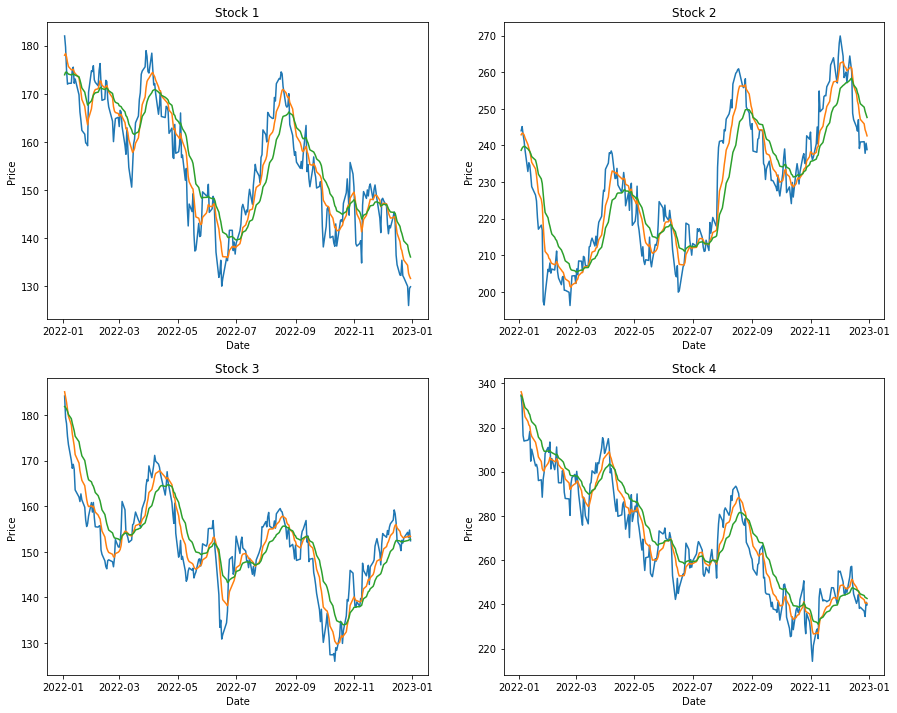

In [9]:
# lets plot each stock with the new ema's
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

ax = ax.flatten()

for i, df in enumerate([aapl_2022, adp_2022, awk_2022, msft_2022]):
    ax[i].plot(df.index, df['Close'], label = f'{df}'+ ' Close')
    ax[i].plot(df.index, df['EMA9'], label = f'{df}'+ ' EMA9')
    ax[i].plot(df.index, df['EMA21'], label = f'{df}'+ ' EMA21')
                       
    ax[i].set_title(f'Stock {i+1}')
    ax[i].set_xlabel('Date')
    ax[i].set_ylabel('Price')


## Let's define our strategy:

- Buy, if EMA9 crosses above EMA21. Close long when EMA9 crosses below EMA21.
- Sell, if EMA9 crosses below EMA21. Close short when EMA 9 crosses above EMA21.

In [10]:
for stock, df in {'AAPL' : aapl_2022,
                   'ADP'  : adp_2022,
                   'AWK'  : awk_2022,
                   'MSFT' : msft_2022}.items():
    
    df['Signal'] = 0 
    position = 0
    
    for i in range(1,len(df)):
        if df['EMA9'][i] > df['EMA21'][i] and df['EMA9'][i-1] <= df['EMA21'][i-1]:
            # Long position
            position = 1
            # Buy
            df['Signal'][i] = 1
            
        elif df['EMA9'][i] < df['EMA21'][i] and df['EMA9'][i-1] >= df['EMA21'][i-1]:
            # Short position
            position = -1
            # Sell
            df['Signal'][i] = -1
            
        elif df['EMA9'][i] < df['EMA21'][i] and position == 1:
            # Close long
            position = 0 
            # Sell
            df['Signal'][i] = -1
    
        elif df['EMA9'][i] > df['EMA21'][i] and position == -1:
            # Close short
            position = 0  
            # Buy
            df['Signal'][i] = 1
    
    df['Daily % Change'] = df['Close'].pct_change()
    df['Strategy Returns'] = df['Signal'].shift(1) * df['Daily % Change']
    df['Cumulative Returns'] = (1 + df['Strategy Returns']).cumprod()
    
    trades = df['Signal'].diff().fillna(0)
    df['Holding Period'] = trades.groupby((trades != 0).cumsum()).cumcount() + 1
    num_trades = trades.abs().sum()
    avg_holding_period = df['Holding Period'].mean()
    
    wins = df[df['Strategy Returns'] > 0]['Strategy Returns']
    losses = df[df['Strategy Returns'] < 0]['Strategy Returns']
    win_percentage = len(wins) / num_trades
    avg_win = wins.mean()
    avg_loss = losses.mean()
    avg_win_loss_ratio = -avg_win / avg_loss
    
    print('{}: '.format(stock))
    print('-'*45)
    print('Number of trades: {}'.format(num_trades))
    print('Average holding period: {:.1f} days'.format(avg_holding_period))
    print('Win percentage: {:.2f}%'.format(win_percentage * 100))
    print('Average win/loss ratio: {:.2f}'.format(avg_win_loss_ratio))
    print('Cumulative returns: {:.2f}%\n'.format((df['Cumulative Returns'].iloc[-1] - 1) * 100))
    

AAPL: 
---------------------------------------------
Number of trades: 26.0
Average holding period: 15.0 days
Win percentage: 30.77%
Average win/loss ratio: 0.55
Cumulative returns: -1.34%

ADP: 
---------------------------------------------
Number of trades: 26.0
Average holding period: 14.4 days
Win percentage: 19.23%
Average win/loss ratio: 0.82
Cumulative returns: -5.48%

AWK: 
---------------------------------------------
Number of trades: 28.0
Average holding period: 13.9 days
Win percentage: 28.57%
Average win/loss ratio: 0.88
Cumulative returns: 1.57%

MSFT: 
---------------------------------------------
Number of trades: 30.0
Average holding period: 15.1 days
Win percentage: 33.33%
Average win/loss ratio: 0.80
Cumulative returns: 6.27%



<ipython-input-10-b3f6f7df18da>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'][i] = -1
<ipython-input-10-b3f6f7df18da>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'][i] = 1
<ipython-input-10-b3f6f7df18da>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'][i] = -1
<ipython-input-10-b3f6f7df18da>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See

Let's plot the results

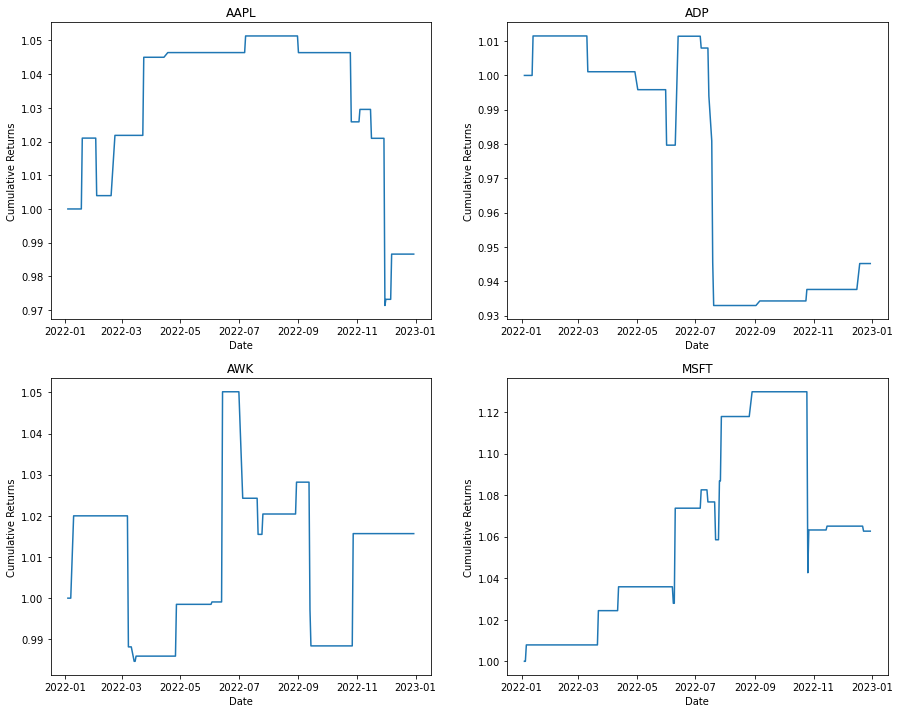

In [11]:
fig2, ax2 = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

ax2 = ax2.flatten()

stock_names = ['AAPL', 'ADP', 'AWK', 'MSFT']
df_list = [aapl_2022, adp_2022, awk_2022, msft_2022]

for i, df in enumerate(df_list):
    
    ax2[i].plot(df.index, df['Cumulative Returns'])
    ax2[i].set_title(stock_names[i])
    ax2[i].set_xlabel('Date')
    ax2[i].set_ylabel('Cumulative Returns')
    

